# Importarea librariior

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, LeavePGroupsOut
from sklearn.metrics import classification_report, confusion_matrix

# Incarcarea setului de date

In [11]:
import kagglehub

# import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")

print("Path to dataset files:", path)

Path to dataset files: /Users/robertochiper/.cache/kagglehub/datasets/vbookshelf/rice-leaf-diseases/versions/1


# Afișarea primelor câteva rânduri pentru a înțelege structura datasetulu

In [12]:
dataset = pd.read_csv('datasets/Crop_recommendation.csv')
print(dataset.head())



    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


# Statistici de bază pentru coloanele numerice

In [13]:
print(dataset.describe())

                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117  


# Verificarea valorilor lipsă

In [14]:
print(dataset.isnull().sum())


N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [15]:
len(dataset.drop_duplicates()) == len(dataset)

True

! Se observa ca nu avem date lipsa in setul de date.

# Verificarea duplicatelor în dataset

In [16]:
num_duplicates = dataset.duplicated().sum()
if num_duplicates > 0:
    print(f"Dataset-ul conține {num_duplicates} rânduri duplicate.")
else:
    print("Nu există rânduri duplicate în dataset.")

Nu există rânduri duplicate în dataset.


# Matricea de corelație pentru a înțelege relațiile dintre caracteristici

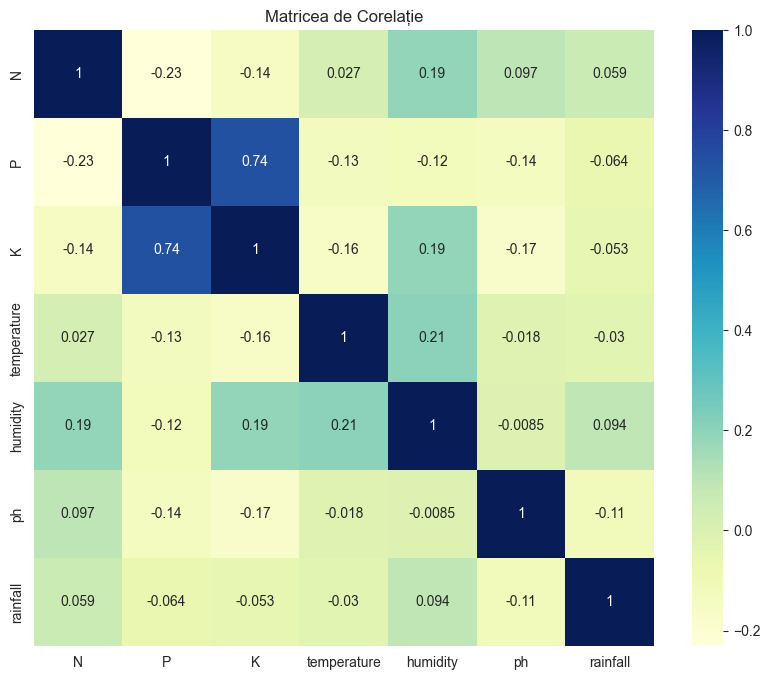

In [17]:
# Selectăm doar coloanele numerice din DataFrame
numeric_dataset = dataset.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_dataset.corr(), annot=True, cmap="YlGnBu")
plt.title('Matricea de Corelație')
plt.show()
# de pus abs intr-o noua celula



# Concluzii pe baza matricii: 
Matricea de corelație ne ajută să identificăm relațiile dintre caracteristici și să evităm redundanțele în model. De exemplu, P și K au o corelație pozitivă puternică, ceea ce indică faptul că pot aduce informații similare. Astfel, putem lua în considerare eliminarea uneia dintre aceste caracteristici pentru a reduce multicoliniaritatea și a simplifica modelul. De asemenea, caracteristicile fără corelații puternice pot fi păstrate, deoarece aduc informații unice care pot contribui la îmbunătățirea performanței modelului.


# Distribuția fiecărui parametru din dataset

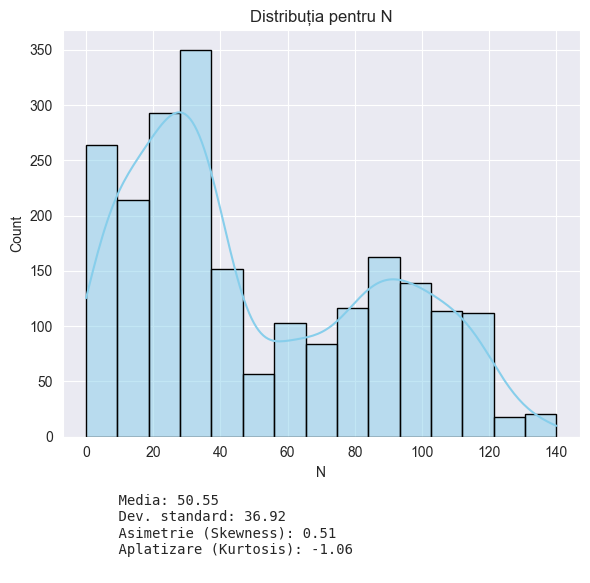

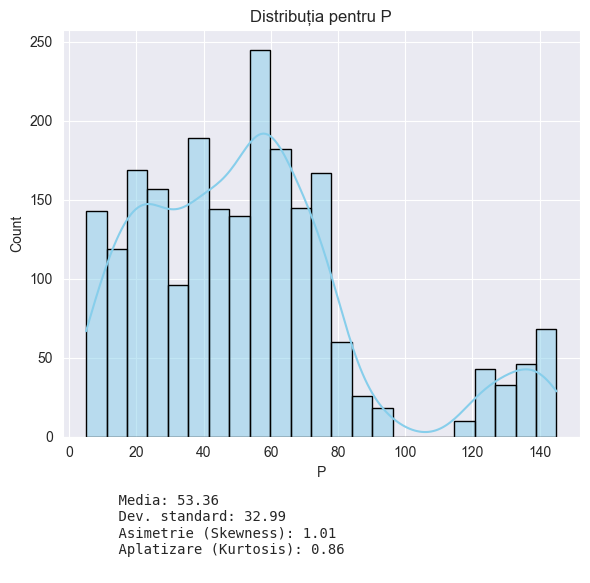

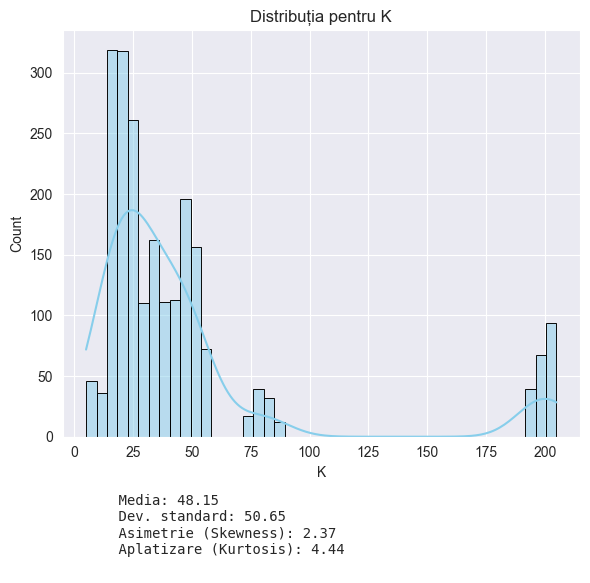

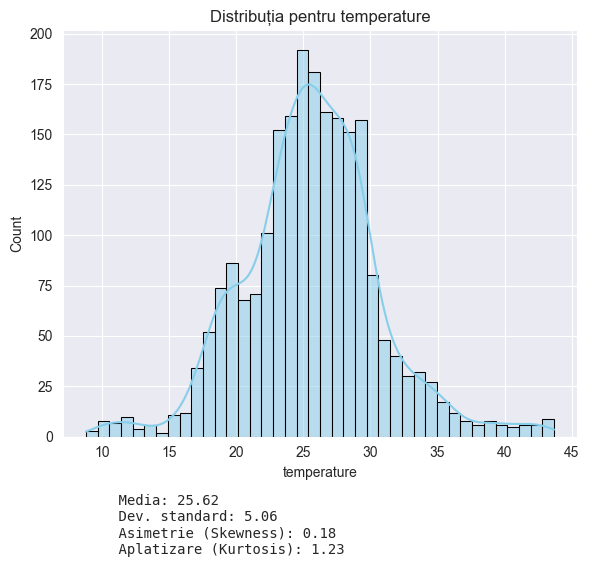

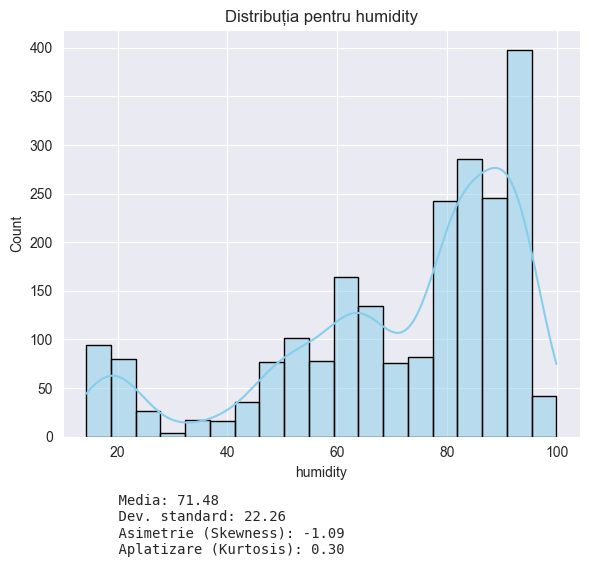

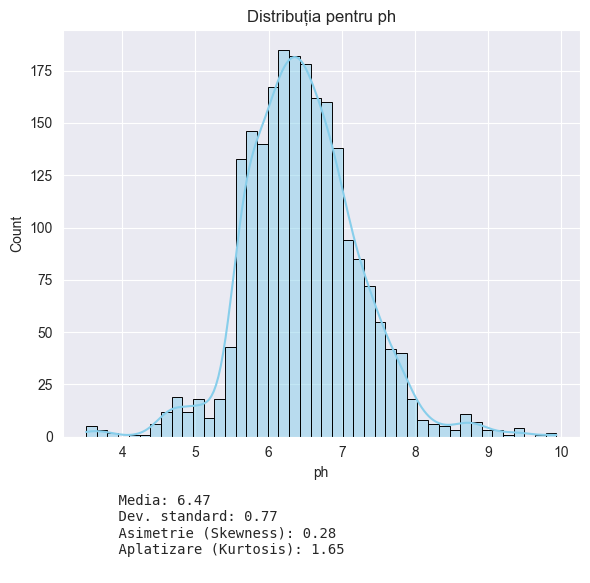

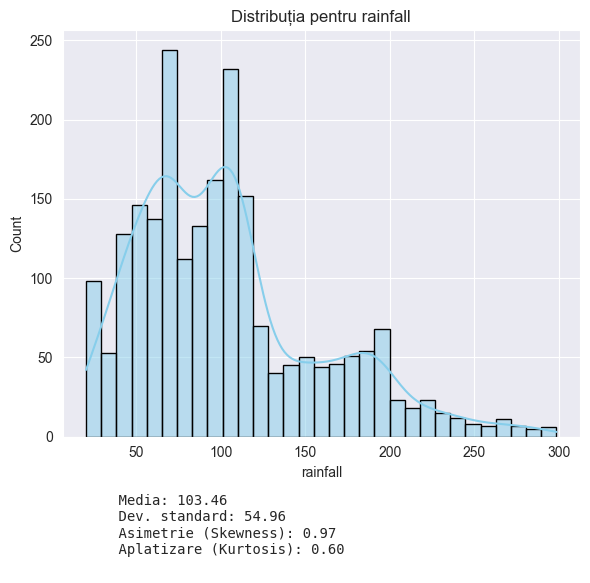

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, skew

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
for feature in features:
    plt.figure(figsize=(6, 5))

    # Histogramă + KDE
    sns.histplot(dataset[feature], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribuția pentru {feature}')
    plt.xlabel(feature)

    # Calcul statistici
    data = dataset[feature].dropna()
    mean_val = data.mean()
    std_val = data.std()
    skew_val = skew(data)
    kurt_val = kurtosis(data)

    # Afișare sub grafic
    textstr = f'''
    Media: {mean_val:.2f}
    Dev. standard: {std_val:.2f}
    Asimetrie (Skewness): {skew_val:.2f}
    Aplatizare (Kurtosis): {kurt_val:.2f}
    '''
    plt.gcf().text(0.15, -0.15, textstr, fontsize=10, family='monospace')

    plt.tight_layout()
    plt.show()


# Concluzie privind distribuțiile: 
Distribuțiile parametrilor ne oferă informații valoroase despre variabilitatea și tendințele fiecărei caracteristici. De exemplu, N și K au o distribuție asimetrică spre dreapta, ceea ce indică faptul că majoritatea valorilor sunt concentrate în intervale mai mici, dar există și valori mari (outliers). Pe de altă parte, temperatura și ph-ul au distribuții mai echilibrate, apropiate de normală, ceea ce sugerează stabilitate în aceste măsurători. Aceste informații ne pot ajuta să identificăm posibilele valori extreme care pot influența negativ modelul și să decidem asupra unor strategii de preprocesare, cum ar fi normalizarea sau eliminarea outlier-ilor.


# Diagrama de frecvență pentru culturi pentru a vedea distribuția

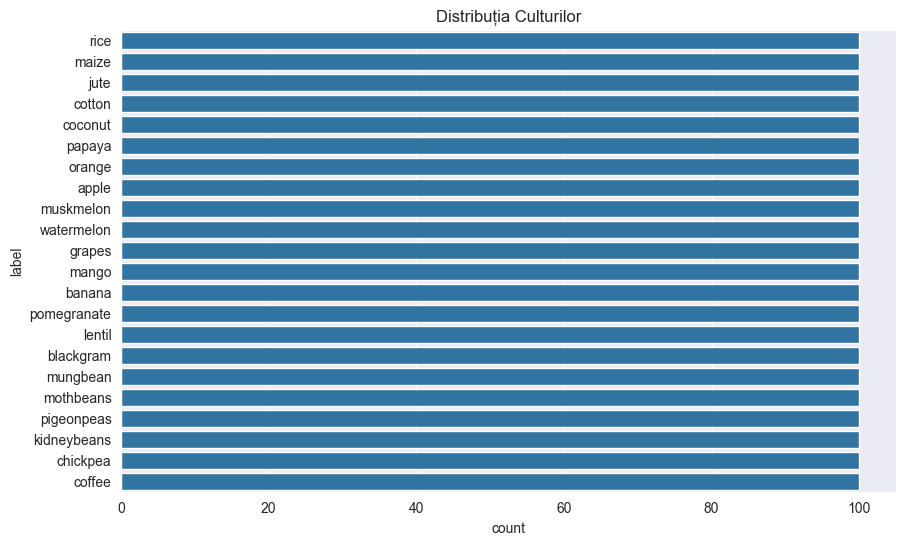

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(y=dataset['label'], order=dataset['label'].value_counts().index)
plt.title('Distribuția Culturilor')
plt.show()
# de afisat numarul de clase

# Concluzie privind distribuția culturilor:
- Distribuția culturilor arată că fiecare cultură are un număr aproximativ egal de înregistrări, ceea ce indică faptul că datasetul este echilibrat. Aceasta este o informație importantă, deoarece un dataset echilibrat va ajuta modelul să învețe în mod corect și să nu fie părtinitor către anumite culturi. De asemenea, acest echilibru ne oferă încredere că modelul va performa bine pe toate clasele de predicție, fără să favorizeze una în detrimentul altora. (acuratetea)

- De asemenea, deoarece datasetul este echilibrat, scorul F1 este o alegere potrivită pentru a evalua performanța modelului, asigurând un echilibru adecvat între precizie și recall pentru toate culturile.

# Impartirea datelor

In [20]:
X = dataset.drop('label', axis=1)
y = dataset['label']
random_state = 42  # Fixăm random_state pentru consistență

# Stocare scoruri
model_performance = {}


# Encodarea etichetelor pentru ținta categorică
- Facem encodarea etichetelor pentru a transforma valorile categorice în format numeric, astfel încât modelul de învățare automată să poată lucra cu ele

In [21]:
from json import encoder
from sympy.physics.continuum_mechanics.beam import numpy
import pickle

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

dataset['label'] = y_encoded
dataset['label'].unique()

import joblib
joblib.dump(label_encoder, "models/crop_label_encoder.pkl")
print("Encoderul a fost salvat în models/crop_label_encoder.pkl")




Encoderul a fost salvat în models/crop_label_encoder.pkl


# Arborele de decizie - Decision Tree
### Ce este un arbore de decizie?
- Un arbore de decizie este un model de învățare automată utilizat pentru clasificare și regresie. Este un model bazat pe o structură ierarhică, în care fiecare nod reprezintă o decizie bazată pe o caracteristică, iar ramurile reprezintă rezultatele posibile ale acelei decizii. La final, frunzele arborelui conțin clasele de predicție. Este ușor de înțeles și vizualizat, ceea ce îl face o alegere bună pentru probleme de clasificare în care interpretabilitatea este importantă. Am ales să folosesc un arbore de decizie pentru problema mea deoarece poate să găsească rapid relații complexe între caracteristicile de intrare și poate să clasifice datele în mod eficient, având în același timp avantajul de a fi un model transparent și ușor de explicat.

### Parametrii Arborelui de Decizie şi efectele lor:
- criterion: Măsura utilizată pentru a decide cum să se împartă un nod (gini sau entropy), care determină impuritatea nodurilor.
-	max_depth: Adâncimea maximă a arborelui, care controlează cât de complex poate fi modelul.
-	min_samples_split: Numărul minim de mostre necesare pentru a împărți un nod.
-	min_samples_leaf: Numărul minim de mostre care trebuie să fie prezente într-un nod frunză.


In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

print("\nEvaluare: Decision Tree")
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier(criterion='gini', random_state=random_state)
scores_dt = cross_val_score(decisionTree, X, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
model_performance['Decision Tree'] = scores_dt.mean()
print(f"Acuratețea medie pentru Decision Tree: {model_performance['Decision Tree']}")



Evaluare: Decision Tree
Acuratețea medie pentru Decision Tree: 0.9868181818181819


# Support Vector Machine (SVM)
### Ce este Support Vector Machine (SVM)?
- Support Vector Machine (SVM) este un algoritm de clasificare supravegheat folosit pentru a separa datele în funcție de anumite caracteristici. Imaginează-ți SVM ca o linie (sau un plan, dacă sunt mai multe dimensiuni) care împarte datele în două grupuri distincte. Scopul SVM este să găsească acea linie sau plan care împarte datele cât mai bine, astfel încât să existe o separare clară între diferitele clase.
SVM funcționează bine atunci când datele sunt liniar separabile. Când datele nu sunt ușor de separat, SVM folosește kernel trick pentru a transforma datele într-un spațiu cu mai multe dimensiuni, astfel încât să poată trasa un hiperplan care să le separe mai bine.

### Parametrii Modelului SVM
- Modelul SVM folosește un parametru important - gamma.
•	Gamma controlează influența fiecărui punct de antrenament. Pentru acest test, am utilizat gamma='auto', ceea ce înseamnă că influența fiecărui punct este proporțională cu numărul de caracteristici al setului de date.
- SVM poate folosi diferite funcții kernel pentru a măsura distanța între punctele de date, cum ar fi kernel liniar, polinomial sau RBF (Radial Basis Function). În acest test, am folosit parametrul default pentru kernel, care este RBF.



In [23]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nEvaluare: SVM")
from sklearn.svm import SVC

SVM = SVC(gamma='scale', kernel='rbf', C=100, random_state=random_state)
scores_svm = cross_val_score(SVM, X_scaled, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
model_performance['SVM'] = scores_svm.mean()
print(f"Acuratețea medie pentru SVM: {model_performance['SVM']}")


Evaluare: SVM
Acuratețea medie pentru SVM: 0.9863636363636363


# Gaussian Naive Bayes Classifier
### Ce este Gaussian Naive Bayes?
- Gaussian Naive Bayes (GNB) este un model de clasificare bazat pe teorema lui Bayes, utilizat pentru date continue. Acesta presupune că datele sunt distribuite normal (adică urmează o distribuție gaussiană, de tip clopot). Modelul Naive Bayes este numit naiv deoarece presupune că toate caracteristicile sunt independente una de cealaltă, ceea ce în multe cazuri nu este adevărat, dar face algoritmul extrem de rapid și eficient.

### Parametrii Modelului Logistic Regression
- Modelul Logistic Regression utilizează următorii parametri importanți:
    -	C: reprezintă inversul parametrului de regularizare și controlează forța penalizării. Valorile mari pentru C încearcă să clasifice corect fiecare punct de antrenament, în timp ce valorile mici permit mai multe erori pentru a obține o generalizare mai bună.
    -	Solver: algoritmul folosit pentru optimizarea funcției de cost. Modelul poate folosi diferite metode de optimizare, precum lbfgs, liblinear, sag, etc., fiecare având avantaje pentru diferite tipuri de seturi de date.
    -	Max_iter: numărul maxim de iterații pentru algoritmul de optimizare. Într-un context cu un număr mare de caracteristici, acest parametru poate fi ajustat pentru a asigura convergența modelului.




In [24]:
print("\nEvaluare: Gaussian Naive Bayes")
from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()
scores_nb = cross_val_score(NaiveBayes, X, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
model_performance['Naive Bayes'] = scores_nb.mean()
print(f"Acuratețea medie pentru Gaussian Naive Bayes: {model_performance['Naive Bayes']}")

#Antrenam modelul
# 1. Fit real pe tot dataset-ul
NaiveBayes.fit(X, dataset['label'])

# 3. Salvăm modelul într-un fișier .pkl
with open("NB_model.pkl", "wb") as f:
    pickle.dump(NaiveBayes, f)

print("Modelul NB a fost salvat în NB_model.pkl")


Evaluare: Gaussian Naive Bayes
Acuratețea medie pentru Gaussian Naive Bayes: 0.9950000000000001
Modelul NB a fost salvat în NB_model.pkl


### Ce este Random Forest?
- Random Forest este un algoritm de machine learning folosit pentru probleme de clasificare și regresie. Acesta este un ensemble learning method, adică combină rezultatele mai multor modele individuale (în acest caz arbori de decizie) pentru a obține o predicție finală. Random Forest este foarte eficient pentru că reducere varianța și suprapotrivirea (overfitting) caracteristică unui singur arbore de decizie.


In [25]:
print("\nEvaluare: Random Forest")
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=20, random_state=0)
scores_rf = cross_val_score(RF, X, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
model_performance['Random Forest'] = scores_rf.mean()
print(f"Acuratețea medie pentru Random Forest: {model_performance['Random Forest']}")


Evaluare: Random Forest
Acuratețea medie pentru Random Forest: 0.9945454545454545


# Logistic Regression
## Ce este Logistic Regression?
- Logistic Regression este un model de clasificare folosit pentru a estima probabilitatea ca o observație să aparțină unei anumite clase. Acesta folosește o funcție logistică (sau sigmoidă) pentru a transforma scorul liniar într-o probabilitate. Modelul este potrivit pentru probleme de clasificare binară, dar poate fi extins și la clasificări multiclase.
Am ales să folosim Logistic Regression pentru această problemă deoarece este un model simplu, interpretabil și eficient, care poate să ofere o bază solidă pentru compararea cu alte modele mai complexe.

In [26]:
print("\nEvaluare: Logistic Regression")
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
LogReg = LogisticRegression(solver="lbfgs", C=1, max_iter=1000, random_state=random_state)
scores_lr = cross_val_score(LogReg, X_scaled, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
model_performance['Logistic Regression'] = scores_lr.mean()
print(f"Acuratețea medie pentru Logistic Regression: {model_performance['Logistic Regression']}")



Evaluare: Logistic Regression
Acuratețea medie pentru Logistic Regression: 0.9713636363636363


### Ce este XGBoost?
- XGBoost (eXtreme Gradient Boosting) este un algoritm de machine learning folosit pentru probleme de clasificare și regresie. Este o versiune optimizată a algoritmului Gradient Boosting și se remarcă prin eficiența ridicată, viteza și performanțele sale. XGBoost este capabil să construiască modele complexe în mod incremental, folosind rezultatele modelelor anterioare pentru a învăța din greșeli și a îmbunătăți acuratețea.


In [27]:
import pickle

print("\nEvaluare: XGBoost")
import xgboost as xgb

XB = xgb.XGBClassifier(random_state=random_state)
scores_xb = cross_val_score(XB, X, dataset['label'], cv=5, scoring='accuracy')  # 5-fold cross-validation
model_performance['XGBoost'] = scores_xb.mean()
print(f"Acuratețea medie pentru XGBoost: {model_performance['XGBoost']}")


#Antrenam modelul
# 1. Fit real pe tot dataset-ul
XB.fit(X, dataset['label'])

# 3. Salvăm modelul într-un fișier .pkl
with open("XGBoost_model.pkl", "wb") as f:
    pickle.dump(XB, f)

print("Modelul XGBoost a fost salvat în XGBoost_model.pkl")



Evaluare: XGBoost
Acuratețea medie pentru XGBoost: 0.9927272727272728
Modelul XGBoost a fost salvat în XGBoost_model.pkl


# Vizualizare performanță modele


Comparație între modele
Decision Tree: 0.9868
SVM: 0.9864
Naive Bayes: 0.9950
Random Forest: 0.9945
Logistic Regression: 0.9714
XGBoost: 0.9927


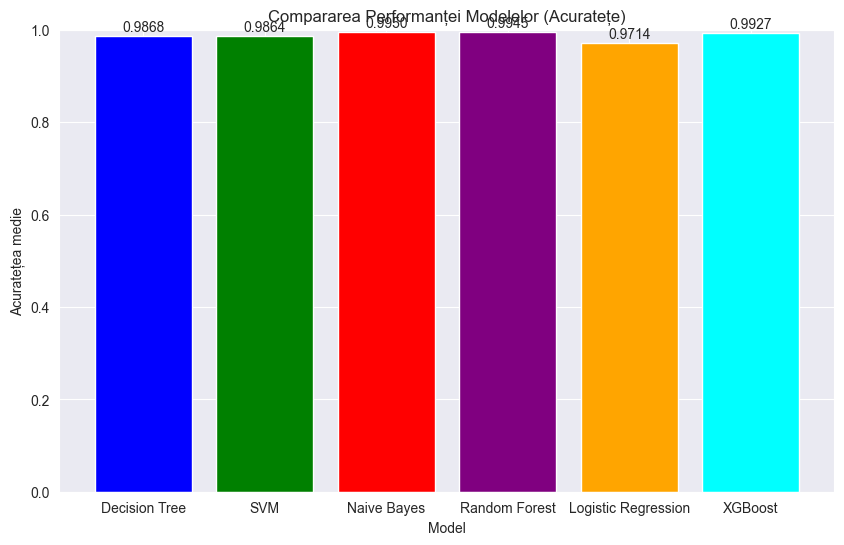

In [28]:
print("\nComparație între modele")

# Afișăm scorurile în consolă
for model, score in model_performance.items():
    print(f"{model}: {score:.4f}")

import matplotlib.pyplot as plt

# Definim o paletă de culori diferite pentru fiecare model
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))
plt.bar(model_performance.keys(), model_performance.values(), color=colors[:len(model_performance)])
plt.xlabel('Model')
plt.ylabel('Acuratețea medie')
plt.title('Compararea Performanței Modelelor (Acuratețe)')
plt.ylim(0, 1)

# Ajustăm afișarea valorilor pe bare cu 4 zecimale
for i, v in enumerate(model_performance.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.show()

In [32]:
# 1) Importuri
import pandas as pd
import xgboost as xgb

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# 2) Pregătirea y (encode dacă e nevoie)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 3) Definirea metricilor
scoring = {
    'accuracy':  'accuracy',
    'precision': 'precision_macro',
    'recall':    'recall_macro',
    'f1':        'f1_macro'
}

# 4) Definirea modelelor (pipeline pentru cele ce trebuie scalate)
models = {
    'Naive Bayes': GaussianNB(),

    'Decision Tree': DecisionTreeClassifier(
        criterion='gini',
        random_state=42
    ),

    'SVM': SVC(
        kernel='rbf',
        gamma='scale',
        C=100,
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=20,
        random_state=0
    ),

    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            solver='lbfgs',
            C=1,
            max_iter=5000,       # mărim iterațiile
            random_state=42
        ))
    ]),

    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='mlogloss'  # pentru a evita warning-uri vechi
    )
}

# 5) Cross-validation pe fiecare model
results = {}
for name, model in models.items():
    # alege ce y folosești: y_enc pentru XGBoost, altfel y
    y_target = y_enc if name == 'XGBoost' else y
    cvres = cross_validate(
        model,
        X,
        y_target,
        cv=5,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    # media scorurilor pe fold-uri
    results[name] = {
        metric: {
            'train': cvres[f'train_{metric}'].mean(),
            'valid': cvres[f'test_{metric}'].mean()
        }
        for metric in scoring
    }

# 6) Construirea și afișarea DataFrame-ului
df = pd.DataFrame({
    (model, metric): scores
    for model, metrics in results.items()
    for metric, scores in metrics.items()
}).T.unstack()

df.columns.names = ['metric','set']
display(df)

# 7) (Opțional) Salvare CSV
df.to_csv('metrics_iteratia1.csv', index=True)

# 8) Afişare text a tabelului
print("\n=== Rezultate metrici (text) ===\n")
print(df.to_string())



metric                  train                                   valid  \
set                  accuracy        f1 precision    recall  accuracy   
Decision Tree        1.000000  1.000000  1.000000  1.000000  0.986818   
Logistic Regression  0.975227  0.975207  0.975603  0.975227  0.971364   
Naive Bayes          0.994886  0.994881  0.995059  0.994886  0.995000   
Random Forest        1.000000  1.000000  1.000000  1.000000  0.994545   
SVM                  0.991818  0.991812  0.991960  0.991818  0.986364   
XGBoost              1.000000  1.000000  1.000000  1.000000  0.992727   

metric                                             
set                        f1 precision    recall  
Decision Tree        0.986781  0.987761  0.986818  
Logistic Regression  0.971250  0.973445  0.971364  
Naive Bayes          0.994979  0.995451  0.995000  
Random Forest        0.994539  0.994838  0.994545  
SVM                  0.986211  0.987498  0.986364  
XGBoost              0.992731  0.993060  0.992727


=== Rezultate metrici (text) ===

metric                  train                                   valid                              
set                  accuracy        f1 precision    recall  accuracy        f1 precision    recall
Decision Tree        1.000000  1.000000  1.000000  1.000000  0.986818  0.986781  0.987761  0.986818
Logistic Regression  0.975227  0.975207  0.975603  0.975227  0.971364  0.971250  0.973445  0.971364
Naive Bayes          0.994886  0.994881  0.995059  0.994886  0.995000  0.994979  0.995451  0.995000
Random Forest        1.000000  1.000000  1.000000  1.000000  0.994545  0.994539  0.994838  0.994545
SVM                  0.991818  0.991812  0.991960  0.991818  0.986364  0.986211  0.987498  0.986364
XGBoost              1.000000  1.000000  1.000000  1.000000  0.992727  0.992731  0.993060  0.992727
